## Functions and Data

In [1]:
import datetime
import copy
import os


import numpy as np
from numpy.random import normal as rnorm, multinomial as rmultinomial
import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


plt.style.use(['seaborn-talk'])

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


C:\Users\noah_\AppData\Local\Temp\ipykernel_14968\3126415308.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-talk'])


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=sm.tools.sm_exceptions.DomainWarning)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
data_W = pd.read_excel(r"data/Hourly Weather and No Outlier Wachapreague Data.xlsx", parse_dates=[r"Date"])
data_W = data_W.drop(
    columns=["Wind Direction (degrees)", "Water Level Anomalies (m)"]
    ).rename(
    columns = {"Date": "time_min", 
                "Wind Speed (m/s)": "wind",
               "Air Pressure (mb)": "airpressure",
               "Precipitation (mm/hr)": "precipitation", 
               "Temperature ©": "temperature",
               "Salinity (ppt)": "salinity",
               "DO (mg/L)": "ODO",
               "Water Level (m)": "waterlevel",
               "Log10(Chl+1) (log10(ug/L))": "log10_chlorophyll",
              }
    ).set_index("time_min")

data_W["chlorophyll"] = data_W["log10_chlorophyll"].map(lambda x: np.power(10, x))
data_W["date"] = data_W.index.date
data_W = data_W.dropna()

# data_W = pd.read_excel(r"data/Corrected W All.xlsx", sheet_name = "Sheet1", parse_dates=[r"Combine"],)
# data_W = data_W.drop(
#     columns=["MM/DD/YY", "HH:mm:SS", "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "Unnamed: 15"]
#     ).rename(
#     columns = {"Combine": "time_min",
#                "Temp ('C)": "temperature",
#                "SpCond (ms/cm)": "conductivity",
#                "Salinity (ppt)": "salinity",
#                "ODO (mg/L)": "ODO",
#                "Turb (NTU)": "turbidity",
#                "Chl (ug/L)": "chlorophyll",
#               }
#     ).set_index("time_min")
# data_W["date"] = data_W.index.date
# data_W["log10_chlorophyll"] = data_W["chlorophyll"].map(np.log10)
# data_W = data_W.dropna()


In [4]:
data_W

,wind,airpressure,precipitation,temperature,salinity,ODO,log10_chlorophyll,waterlevel,chlorophyll,date
time_min,,,,,,,,,,
2016-03-25 20:00:00,1.870000,1012.210000,0.76,16.70975,30.9550,8.0425,0.360495,0.938,2.293480,2016-03-25
2016-03-25 21:00:00,2.500000,1013.730000,0.53,16.43975,31.2575,7.8200,0.319070,1.127,2.084826,2016-03-25
2016-03-25 22:00:00,3.690000,1014.980000,0.20,15.83275,31.4425,7.8650,0.327645,1.268,2.126401,2016-03-25
2016-03-25 23:00:00,4.180000,1015.490000,0.03,15.43950,31.4775,7.8525,0.330899,1.324,2.142390,2016-03-25
2016-03-26 00:00:00,3.150000,1016.750000,0.00,15.45900,31.3925,7.7400,0.325592,1.238,2.116372,2016-03-26
...,...,...,...,...,...,...,...,...,...,...
2022-12-30 09:00:00,1.970000,1027.990000,0.00,3.83875,30.2475,10.8475,0.256034,0.154,1.803160,2022-12-30
2022-12-30 10:00:00,2.600000,1027.950000,0.00,3.88500,31.0050,11.0250,0.216035,0.408,1.644506,2022-12-30
2022-12-30 17:00:00,0.850000,1024.550000,0.00,5.93050,31.7200,11.5850,0.402570,0.694,2.526794,2022-12-30


In [5]:

data_WW = pd.read_excel(r"data/VIMS WQ Data.xlsx", sheet_name = "WW", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )
data_WW_2 = pd.read_excel(r"data/2022-Willis_Wharf ALL Raw (1).xlsx", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )

data_WW = data_WW.drop(
    columns=["Unnamed: 17", "Unnamed: 18", "MM/DD/YY.1", "Flagged or Deleted Data/Notes", "Log10 chl", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)", "Day"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW_2 = data_WW_2.drop(
    columns=["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW = pd.concat([data_WW[data_WW.index.year < 2022], data_WW_2])
data_WW["log10_chlorophyll"] = data_WW["chlorophyll"].map(np.log10)
data_WW = data_WW.dropna()


d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: invalid value encountered in log10
  new_values = map_f(values, mapper)


In [6]:
data_WW

,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll
time_min,,,,,,,,,
2018-10-12 12:53:04,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711
2018-10-12 14:03:38,2018-10-12,24.615,46.755,30.38,7.86,6.37,19.17,6.34,0.802089
2018-10-12 14:17:40,2018-10-12,24.757,46.513,30.20,7.85,6.54,20.72,6.97,0.843233
2018-10-12 14:32:41,2018-10-12,24.898,46.381,30.10,7.85,6.71,21.37,7.67,0.884795
2018-10-12 14:47:41,2018-10-12,24.940,46.315,30.05,7.86,6.81,23.71,7.33,0.865104
...,...,...,...,...,...,...,...,...,...
2022-12-24 05:02:12,2022-12-24,4.105,46.071,29.17,7.84,9.80,17.23,3.00,0.477121
2022-12-24 05:17:12,2022-12-24,3.908,46.023,29.11,7.84,9.79,17.85,3.09,0.489958
2022-12-24 05:32:12,2022-12-24,3.921,46.073,29.15,7.83,9.72,21.78,3.06,0.485721


In [7]:
def matmul_log(A, log_b):
    res = []
    for tmp_line in A:
        if np.any(tmp_line == 0.) :
            if np.all(tmp_line == 0.) :
                res.append(logsumexp(np.log([1 / len(tmp_line) for i in range(len(tmp_line))]) + log_b))
            else:
                res.append(logsumexp(np.log(tmp_line[tmp_line != 0]) + log_b[tmp_line != 0]))
        else:
            res.append(logsumexp(np.log(tmp_line) + log_b))
    return np.array(res)


In [8]:
class MSLR():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None):
        self.n_components = n_components
        self.n_iter = n_iter
        self.covariance_type = covariance_type 
        self.tol = 0.0
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
        
        return
    
    
    def fit_predict(self, X, Y, X_test, is_multiple_sequence = False, forecast_horizon = 1):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        n_seq = len(list_X)
        list_T = [len(i) for i in list_X]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        K = self.n_components
        self.n_features = p
        
        self.transmat_ = np.array([[1. / K for j in range(K)] for i in range(K)])

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
            list_list_log_emission = [[np.copy(list_cur_mat_log_b[index_X][i, :]) for i in range(T)] for index_X, T in enumerate(list_T)]
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(self.transmat_), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(self.transmat_[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(self.transmat_[ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self.transmat_ = self._calc_transmat(list_tmp_array3d_log_epsilon)
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol):
                break
            
            #print("epoch % s, loglik = % s" % (epoch, loglik))
            #print(cur_list_mvn_mean_cov)
            #print(cur_transmat)
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= np.max(tmp)
            tmp = np.exp(tmp)
            tmp /= np.sum(tmp)
            self.list_last_posterior[ii] = tmp
        
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = self.list_last_posterior[ii] @ np.linalg.matrix_power(self.transmat_, forecast_horizon)
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_transmat(self, list_tmp_array3d_log_epsilon):
        K = self.n_components
        cur_transmat = np.zeros((K, K)) 
        for ii in range(K):
            tmp_list_log_prob = []
            for jj in range(K):
                tmp_log_prob = []
                for index_X in range(len(list_tmp_array3d_log_epsilon)):
                    tmp_log_prob.append(logsumexp(list_tmp_array3d_log_epsilon[index_X][:, ii, jj]))
                tmp_list_log_prob.append(logsumexp(tmp_log_prob))
            tmp_list_log_prob = np.array(tmp_list_log_prob)
            tmp_list_log_prob -= np.max(tmp_list_log_prob)
            tmp_prob = np.exp(tmp_list_log_prob)
            tmp_prob /= sum(tmp_prob)
            cur_transmat[ii, :] = tmp_prob
        return cur_transmat
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
# def _test_MSLR():
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     T = 10000
    
#     list_X, list_Y = [], []
#     list_X_test = []
#     for ii in range(5):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, 3))
#         X_test = np.random.normal(loc=1.0, scale=5.0, size=(1, 3))
#         Y, list_h_label = [], []
#         for tt in range(T):
#             if tt == 0:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = init_prob, size = 1))
#             else:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = transmat[tmp_h_label], size = 1))
#             list_h_label.append(tmp_h_label)
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_X_test.append(X_test)
        
#     mslr = MSLR(n_components=3, covariance_type="full", n_iter=10)
#     pred = mslr.fit_predict(list_X, list_Y, list_X_test, is_multiple_sequence=True)
#     print(pred)
#     print(mslr.transmat_)
#     print(mslr.startprob_)
#     for tmp_lr, tmp_cov in mslr.list_lr_cov:
#         print(tmp_lr.coef_)
#         print(tmp_lr.intercept_)
#         print(tmp_cov)

#     return


# _test_MSLR()


In [9]:
class MSLRX():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None, 
                 is_logistic_regression_CV = False, logistic_regression_C = 1e10, is_logistic_regression_standardized = False,
                is_state_coef_indep = False, is_ordinal_logit = False, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.is_logistic_regression_CV = is_logistic_regression_CV
        self.logistic_regression_C = logistic_regression_C
        self.is_state_coef_indep = is_state_coef_indep
        self.is_ordinal_logit = is_ordinal_logit    # only valid when the response is 1-dim so we could sort it
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
        
        self.is_logistic_regression_standardized = is_logistic_regression_standardized
        if is_logistic_regression_standardized:
            self.standardizer = StandardScaler()
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    if self.is_state_coef_indep or self.is_ordinal_logit:
                        if self.is_initialized:
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            tmp_new_exog = [int(i == ii_index) for i in range(K)]
                            tmp_new_exog.extend(tmp_exog)
                            tmp_prob = self.logit_clf.predict_proba(np.array([tmp_new_exog]))[0]
                            if self.is_ordinal_logit:
                                tmp_prob = tmp_prob[self.list_sorted_index_to_original_index]
                            
                        else:
                            tmp_prob = [1 / K for i in range(K)]
                    else:
                        tmp_log_prob = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                        tmp_log_prob -= np.max(tmp_log_prob)
                        tmp_prob = np.exp(tmp_log_prob)
                        tmp_prob /= np.sum(tmp_prob)
                    tmp_trans_mat.append(tmp_prob)
                list_trans_mat.append(tmp_trans_mat)
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        if self.is_ordinal_logit:
            self.list_sorted_index = np.argsort([i[0] for i, j in self.list_mvn_mean_cov])
            self.list_sorted_index_to_original_index = [i for i, j in sorted(list(enumerate(self.list_sorted_index)), key = lambda x: x[1])]
            #print(self.list_mvn_mean_cov)
            #print([i[0] for i, j in self.list_mvn_mean_cov])
            #print(self.list_sorted_index, self.list_sorted_index_to_original_index)
        
        if self.is_state_coef_indep or self.is_ordinal_logit:
            K = self.n_components
            if self.is_ordinal_logit:
                logit_clf = mord.LogisticAT(alpha = 1 / self.logistic_regression_C, verbose = 0, max_iter = 100)
            else:
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            
            for ii in range(K):
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            jj_index = self.list_sorted_index[jj] if self.is_ordinal_logit else jj
                            
                            tmp_exog = [int(i == ii_index) for i in range(K)]
                            tmp_exog.extend(exog[tt])
                            
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(tmp_exog)
                                tmp_y_nan.append(jj_index)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(tmp_exog)
                                tmp_y.append(jj_index)
                                tmp_weight.append(tmp_weight_cell)
            
            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X.extend(tmp_X_nan)
                    tmp_y.extend(tmp_y_nan)
                    tmp_weight.extend([1 / K for i in range(len(tmp_weight_nan))])

            logit_clf.fit(np.array(tmp_X), np.array(tmp_y), np.array(tmp_weight)) 
            self.logit_clf = logit_clf
            
        else:
            K = self.n_components
            self.list_coef_, self.list_intercept_ = [], []
            for ii in range(K):
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                tmp_X, tmp_y, tmp_weight = [], [], []
                tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(exog[tt])
                                tmp_y_nan.append(jj)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(exog[tt])
                                tmp_y.append(jj)
                                tmp_weight.append(tmp_weight_cell)

                if len(tmp_y_nan) >= 1: 
                    print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                    if len(set(tmp_y)) < K:
                        tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                        tmp_weight = 1

                logit_clf.fit(tmp_X, tmp_y, tmp_weight)

                if self.n_components == 2:
                    tmp_coef = np.array([- logit_clf.coef_.flatten(), logit_clf.coef_.flatten()])
                    tmp_intercept = np.array([- logit_clf.intercept_[0], logit_clf.intercept_[0]])
                else:
                    tmp_coef = logit_clf.coef_[np.argsort(logit_clf.classes_), :]
                    tmp_intercept = logit_clf.intercept_[np.argsort(logit_clf.classes_)]
                self.list_coef_.append(np.transpose(tmp_coef))
                self.list_intercept_.append(tmp_intercept)
                
        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False, exog_additional = None):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
            list_exog_additional = [np.array(i) for i in exog_additional] if exog_additional is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            list_exog_additional = [np.array(exog_additional)] if exog_additional is not None else None
            
        if self.is_logistic_regression_standardized:
            self.standardizer.fit(np.concatenate(list_exog))
            list_exog = [self.standardizer.transform(i, copy=True) for i in list_exog]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = (p_exog, K)) for i in range(K)]
        self.list_intercept_ = [np.zeros(shape = K) for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
            
        list_transmat_additional = self._est_trans_mat(list_exog_additional) if list_exog_additional is not None else None
        
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            tmp_transmat = list_cur_list_trans_mat[ii][-1]
            if list_transmat_additional is not None:
                for tmp_transmat_additional in list_transmat_additional[ii]:
                    tmp_transmat = tmp_transmat @ tmp_transmat_additional
            self.list_log_pred_posterior.append(matmul_log(np.transpose(tmp_transmat), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
            
        if self.is_logistic_regression_standardized:
            list_exog_test = [self.standardizer.transform(i, copy=True) for i in list_exog_test]
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRX():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRX()")
    
#     np.random.seed(434)
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(10):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRX(n_components=3, covariance_type="full", n_iter=10, is_logistic_regression_standardized = True)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True,
#                             exog_additional = [exog[:1] for X in list_X],
#                             )
#     print(pred)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRX()


In [10]:
class MSLRXSoluIII():
    
    def __init__(self, n_components = 2, covariance_type="full", reg_method = "OLS", kargs_reg = None, n_iter = 10, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    tmp_prob_1 = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                    tmp_prob_1 = max(min(tmp_prob_1, 1 - 1e-5), 1e-5)
                    tmp_prob_0 = 1 - tmp_prob_1
                    tmp_trans_mat.append([tmp_prob_0, tmp_prob_1])
                list_trans_mat.append(np.array(tmp_trans_mat))
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        K = self.n_components
        self.list_coef_, self.list_intercept_ = [], []
        for ii in range(K):
            
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                T = len(array3d_log_epsilon)
                for tt in range(T):
                    for jj in range(K):
                        tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                        if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                            tmp_X_nan.append(exog[tt])
                            tmp_y_nan.append(jj)
                            tmp_weight_nan.append(tmp_weight_cell)
                        else:
                            tmp_X.append(exog[tt])
                            tmp_y.append(jj)
                            tmp_weight.append(tmp_weight_cell)

            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                    tmp_weight = 1
            
            tmp_X = sm.add_constant(tmp_X, has_constant='add', prepend=True)
            res_glm = sm.GLM(exog = tmp_X, endog = tmp_y, family=sm.families.Binomial(link = sm.families.links.identity()), freq_weights = tmp_weight).fit()
            
            tmp_intercept = res_glm.params[0]
            tmp_coef = np.array(res_glm.params[1:])
            
            self.list_coef_.append(tmp_coef) 
            self.list_intercept_.append(tmp_intercept)

        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False, exog_additional = None):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
            list_exog_additional = [np.array(i) for i in exog_additional] if exog_additional is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            list_exog_additional = [np.array(exog_additional)]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = p_exog) for i in range(K)]
        self.list_intercept_ = [1 / K for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []

        list_transmat_additional = self._est_trans_mat(list_exog_additional) if list_exog_additional is not None else None
        
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            
            tmp_transmat = list_cur_list_trans_mat[ii][-1]
            if list_transmat_additional is not None:
                for tmp_transmat_additional in list_transmat_additional[ii]:
                    tmp_transmat = tmp_transmat @ tmp_transmat_additional
            self.list_log_pred_posterior.append(matmul_log(np.transpose(tmp_transmat), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRXSoluIII():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRXSoluIII()")
    
#     np.random.seed(434)
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.1], [ 0.3, 0.7]])
#     init_prob = np.array([1 / 3, 2 / 3])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(100):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRXSoluIII(n_components=2, covariance_type="full", n_iter=10)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True,
#                             exog_additional=[exog[:1] for X in list_X])
#     print(pred)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRXSoluIII()


In [11]:
class SMap:
    
    def __init__(self, theta = 0., reg_method = "OLS", kargs_reg = None):
        
        self.theta = theta
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def fit(self, X, y, sample_weight = None):
        self.X, self.y = np.array(X), np.array(y)
        if sample_weight is None:
            self.sample_weight = np.array([1. for i in range(len(self.X))])
        else:
            self.sample_weight = np.array(sample_weight)
        return
    
    
    def predict(self, X):
        
        X_train, y_train = self.X, self.y
        sample_weight_train = self.sample_weight
        theta = self.theta
        reg_method, kargs_reg = self.reg_method, self.kargs_reg
        
        y_pred = []
        for tmp_X_test in X:
            tmp_X_test = np.array(tmp_X_test)
            tmp_d_vec = np.sqrt(np.sum((X_train - tmp_X_test) ** 2, axis = 1))
            tmp_sample_weight = np.exp(- theta * tmp_d_vec / tmp_d_vec.mean())
            tmp_sample_weight *= sample_weight_train
            tmp_reg = reg_method(**kargs_reg)
            tmp_reg.fit(X_train, y_train, sample_weight = tmp_sample_weight)
            tmp_pred = tmp_reg.predict([tmp_X_test])[0]
            y_pred.append(tmp_pred)
            
        y_pred = np.array(y_pred)
        return y_pred
            
        
# def _test_SMap():
    
#     N, p, n_test = 10000, 5, 1000
#     beta = np.random.uniform(size = p)
#     X = np.random.normal(size = (N, p))
#     y = X @ beta + 2 + np.random.normal(size = N)
    
#     reg = SMap(theta = 0.5)
#     reg.fit(X[:-n_test], y[:-n_test])
#     y_pred = reg.predict(X[-n_test:])
#     print("r2 =", r2_score(y_true=y[-n_test:], y_pred = y_pred))
    
#     return
    
    
# _test_SMap()        
        

In [12]:
class SMapCV:
    
    def __init__(self, thetas = (0.0, 0.5, 1.0, 1.5, 2.0, ), reg_method = "OLS", kargs_reg = None):
        
        self.thetas = thetas
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def fit(self, X, y, sample_weight = None):
        
        X, y = np.array(X), np.array(y)
        self.X, self.y = X, y
        if sample_weight is None:
            sample_weight = np.array([1. for i in range(len(self.X))])
        else:
            sample_weight = np.array(sample_weight)
        self.sample_weight = sample_weight
        
        dict_theta_pred = {i: [] for i in self.thetas}
        y_true = []
        sample_weight_true = []
        
        kf = KFold(n_splits=10, shuffle = True, random_state = 434)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            sample_weight_train, sample_weight_test = sample_weight[train_index], sample_weight[test_index]
            
            y_true.extend(y_test)
            sample_weight_true.extend(sample_weight_test)
            
            for theta in self.thetas:
                tmp_smap = SMap(theta = theta, reg_method = self.reg_method, kargs_reg = self.kargs_reg)
                tmp_smap.fit(X_train, y_train, sample_weight = sample_weight_train)
                y_pred = tmp_smap.predict(X_test)
                dict_theta_pred[theta].extend(y_pred)
                
        list_theta_r2 = []
        for theta in self.thetas:
            tmp_r2 = r2_score(y_true = y_true, y_pred = dict_theta_pred[theta], sample_weight = sample_weight_true)
            list_theta_r2.append((theta, tmp_r2))
        list_theta_r2.sort(key = lambda x: x[1], reverse = True)        
        theta_opt = list_theta_r2[0][0]
        
        self.theta = theta_opt
        
        return
    
    
    def predict(self, X):
        
        X_train, y_train = self.X, self.y
        theta = self.theta
        reg_method, kargs_reg = self.reg_method, self.kargs_reg
        
        y_pred = []
        for tmp_X_test in X:
            tmp_X_test = np.array(tmp_X_test)
            tmp_d_vec = np.sqrt(np.sum((X_train - tmp_X_test) ** 2, axis = 1))
            tmp_sample_weight = np.exp(- theta * tmp_d_vec / tmp_d_vec.mean())
            tmp_reg = reg_method(**kargs_reg)
            tmp_reg.fit(X_train, y_train, sample_weight = tmp_sample_weight)
            tmp_pred = tmp_reg.predict([tmp_X_test])[0]
            y_pred.append(tmp_pred)
            
        y_pred = np.array(y_pred)
        return y_pred
            
        
# def _test_SMapCV():
    
#     N, p, n_test = 1000, 5, 100
#     beta = np.random.uniform(size = p)
#     X = np.random.normal(size = (N, p))
#     y = X @ beta + 2 + np.random.normal(size = N)
    
#     reg = SMapCV()
#     reg.fit(X[:-n_test], y[:-n_test])
#     y_pred = reg.predict(X[-n_test:])
#     print("theta = ", reg.theta)
#     print("r2 =", r2_score(y_true=y[-n_test:], y_pred = y_pred))
    
#     return
    
    
# _test_SMapCV()        
        

## Predictions (WW)

In [58]:
data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


In [59]:
data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])


In [60]:
data_WW_byday = data_WW_byday.dropna().resample("1D").max()

In [61]:
data_WW_byday

,date,conductivity,turbidity,temperature,pH,ODO,salinity_max,salinity_min,log10_chlorophyll,chlorophyll,wind
time_min,,,,,,,,,,,
2018-10-12,2018-10-12,46.978,47.06,24.194146,7.902439,5.84,30.55,28.48,1.295567,19.75,2.774167
2018-10-13,2018-10-13,46.748,29.83,22.100917,7.863437,5.89,30.41,28.41,1.480438,30.23,2.256528
2018-10-14,2018-10-14,46.615,18.17,20.642937,7.871354,6.06,30.33,28.59,1.342620,22.01,1.743472
2018-10-15,2018-10-15,46.385,15.75,21.330021,7.870104,6.32,30.16,28.72,1.330008,21.38,4.257870
2018-10-16,2018-10-16,46.521,18.81,21.417677,7.843646,5.63,30.26,28.59,1.221675,16.66,2.117500
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,2022-12-20,49.115,5.79,5.802531,7.942708,9.53,31.56,28.73,0.429752,2.69,1.510417
2022-12-21,2022-12-21,49.668,9.33,5.474958,7.948021,9.63,31.91,29.18,0.459392,2.88,2.171071
2022-12-22,2022-12-22,49.776,50.00,5.977583,7.944375,9.74,32.03,29.50,0.563481,3.66,4.545590


In [71]:
def _main(data_WW_byday, is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, n_seq_warmup = 6,
          reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          #reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    # Data Preparation
    if is_log:
        array_obs = data_WW_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_WW_byday["chlorophyll"].to_numpy()

    array_datetime = data_WW_byday["date"].to_numpy()
    #array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature"]].to_numpy()
    array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_date = []
    for cc in range(n_seq_warmup, len(list_X)):
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_date = []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))

            mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                          logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslrx.append(tmp_y_pred)

            mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

            mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslr.append(tmp_y_pred)

            tmp_y_true = list_Y[cc][tmp_index_test]
            #tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])

        list_y_true.append(tmp_list_y_true)
        list_y_pred_naive.append(tmp_list_y_pred_naive)
        list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
        list_y_pred_mslr.append(tmp_list_y_pred_mslr)
        list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
        list_y_date.append(tmp_list_y_date)

        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))

        #if cc > 5: break
        
    if is_log:
        thres = np.nanquantile(np.power(10, array_obs), thres_quantile)
    else:
        thres = np.nanquantile(array_obs, thres_quantile)

    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    
    if is_cross:
        max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)
    else:
        max_p = max(list_p_AR)
    
    dict_warmup_evaluation = dict()
    for n_seq_exclude_valid in range(n_seq_warmup, len(list_subseq)):
        
        print()
        print("n_seq_warmup =", n_seq_exclude_valid)
        
        list_res_logitcos_cross = []
        list_res_pred = []
        for start_index in range(7, 20):

            print(start_index)

            X, Y = [], []
            list_index_test_set = []
            list_date_test = []
            for cc, (tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross) in enumerate(zip(list_subseq, list_subseq_datetime, list_subseq_cross)):
                for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):
                    tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1
                    tmp_X = []
                    if is_cross:
                        for tmp_p in list_p_AR_cross:
                            tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
                    for tmp_p in list_p_AR:
                        tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
                    X.append(tmp_X)
                    Y.append([tmp_subseq[tmp_index_test]])

                    if cc >= n_seq_exclude_valid and tmp_index_right >= start_index:
                        list_index_test_set.append(len(Y) - 1)
                        list_date_test.append(tmp_subseq_datetime[tmp_index_test])

            y_true, y_pred = [], []
            y_pred_naive = []
            for tmp_index in list_index_test_set:
                lr = reg_method_func(**kargs_reg)
                #lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
                #lr = SMap(theta = 0.5)
                lr.fit(X[:tmp_index], Y[:tmp_index])
                tmp_y_pred = lr.predict([X[tmp_index]])[0]
                tmp_y_true = Y[tmp_index]
                tmp_y_pred_naive = X[tmp_index][-1]
                y_true.append(tmp_y_true)
                y_pred.append(tmp_y_pred)
                y_pred_naive.append(tmp_y_pred_naive)

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_ar, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_ar, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_ar = y_pred
            print("AR", tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
            
            y_true, y_pred = [], []
            y_pred_naive = []
            for tmp_index in list_index_test_set:
                #lr = reg_method_func(**kargs_reg)
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
                #lr = SMap(theta = 0.5)
                lr.fit(X[:tmp_index], Y[:tmp_index])
                tmp_y_pred = lr.predict([X[tmp_index]])[0]
                tmp_y_true = Y[tmp_index]
                tmp_y_pred_naive = X[tmp_index][-1]
                y_true.append(tmp_y_true)
                y_pred.append(tmp_y_pred)
                y_pred_naive.append(tmp_y_pred_naive)

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_smap, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_smap, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_smap = y_pred
            print("SMap", tmp_r2_smap, tmp_r2_naive, tmp_rocauc_smap, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslrx, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslrx, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslrx = y_pred
            print("MSLRX", tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslrxsolu3[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslrxsolu3, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslrxsolu3, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslrxsolu3 = y_pred
            print("MXLRXSolu3", tmp_r2_mslrxsolu3, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslr, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslr, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslr = y_pred
            print("MSLR", tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)

            list_res_logitcos_cross.append((tmp_r2_naive, tmp_rocauc_naive,
                                            tmp_r2_ar, tmp_rocauc_ar, 
                                            tmp_r2_smap, tmp_rocauc_smap,
                                            tmp_r2_mslrx, tmp_rocauc_mslrx, 
                                            tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, 
                                            tmp_r2_mslr, tmp_rocauc_mslr,
                                           ))
            
            list_res_pred.append((list_date_test, y_true, y_pred_naive, y_pred_ar, y_pred_smap, y_pred_mslrx, y_pred_mslrxsolu3, y_pred_mslr))
            
        dict_warmup_evaluation[n_seq_exclude_valid] = (list_res_logitcos_cross, list_res_pred)
                
    return dict_warmup_evaluation


In [72]:

dict_setting_results = dict()
for is_log in [False]:
    for is_cross in [True, False]:
        for is_phase in [True,]:
            for horizon_forecast in [1, 3, 7, ]:

                #tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearSVR", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("================================================")
                
                dict_setting_results[tmp_setting] = _main(data_WW_byday, n_seq_warmup=1, 
                                                          reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                                          #reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                                          is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast,)



setting = (False, True, True, 1, 'LinearSVR')
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-29 34
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-01-27 2021-03-07 41
	 10 2021-03-10 2021-03-29 21
	 11 2021-04-01 2021-06-28 90
	 12 2021-07-01 2021-07-21 22
	 13 2021-07-29 2021-08-31 35
	 14 2021-09-03 2021-10-27 56
	 15 2021-10-30 2022-01-01 65
	 16 2022-01-15 2022-03-26 72
	 17 2022-03-29 2022-07-23 118
	 18 2022-07-28 2022-12-09 136



C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:28.946501
seq 2 finished 0:06:51.644335
seq 3 finished 0:08:41.391037


C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 4 finished 0:18:15.311674
seq 5 finished 0:27:10.930675
seq 6 finished 0:31:44.591673
seq 7 finished 0:46:23.701673
seq 8 finished 0:48:53.130675
seq 9 finished 0:54:21.478674
seq 10 finished 0:56:39.755675
seq 11 finished 1:11:06.150675
seq 12 finished 1:13:51.345674
seq 13 finished 1:19:05.461675
seq 14 finished 1:28:33.221676
seq 15 finished 1:40:20.579675
seq 16 finished 1:54:15.218673
seq 17 finished 2:19:54.618674
seq 18 finished 2:58:37.090674

n_seq_warmup = 1
7
AR 0.5625834576304666 0.634661140357434 0.9665653495440728 0.9697084830063554
SMap 0.6400832841509824 0.634661140357434 0.9701114488348531 0.9697084830063554
MSLRX 0.5918693159329951 0.634661140357434 0.9652067790365663 0.9697084830063554
MXLRXSolu3 0.616749676184322 0.634661140357434 0.9665192963065303 0.9697084830063554
MSLR 0.5647459033535533 0.634661140357434 0.9651607257990237 0.9697084830063554
8
AR 0.5643672178819745 0.6344376657430502 0.9668713163064833 0.9696954813359528
SMap 0.6421077107978579 0.6344376657

C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:49.511000


C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:06:09.176002
seq 3 finished 0:07:42.682999


C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 4 finished 0:15:24.341999
seq 5 finished 0:23:02.270002
seq 6 finished 0:26:46.986002
seq 7 finished 0:39:18.383000
seq 8 finished 0:41:15.433000
seq 9 finished 0:45:55.333000
seq 10 finished 0:47:49.166999
seq 11 finished 1:01:40.893001
seq 12 finished 1:04:03.785000
seq 13 finished 1:08:59.383002
seq 14 finished 1:18:53.446001
seq 15 finished 1:31:31.267000
seq 16 finished 1:46:20.743999
seq 17 finished 2:13:21.615000
seq 18 finished 2:46:36.594025

n_seq_warmup = 1
7
AR 0.3656650936822722 0.3714468099767826 0.9185173800558416 0.9291733907118522
SMap 0.40177248318775816 0.3714468099767826 0.9147262993416839 0.9291733907118522
MSLRX -0.22455609901281148 0.3714468099767826 0.9066830605292144 0.9291733907118522
MXLRXSolu3 0.3713460835168173 0.3714468099767826 0.917851379389841 0.9291733907118522
MSLR -0.18136809359221395 0.3714468099767826 0.9211301518993827 0.9291733907118522
8
AR 0.3711526097030823 0.37371164620671327 0.9196598586222188 0.9303023189086261
SMap 0.4065107386948945 0

C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:36.859000
seq 2 finished 0:05:36.968000
seq 3 finished 0:07:04.125000


C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 4 finished 0:14:52.263001
seq 5 finished 0:22:09.166002
seq 6 finished 0:25:30.957002
seq 7 finished 0:37:35.081000
seq 8 finished 0:38:58.448001
seq 9 finished 0:43:08.573000
seq 10 finished 0:44:23.005000
seq 11 finished 0:57:12.142000
seq 12 finished 0:58:48.588999
seq 13 finished 1:02:47.944000
seq 14 finished 1:10:58.058039
seq 15 finished 1:21:24.876516
seq 16 finished 1:33:46.032511
seq 17 finished 1:57:15.734856
seq 18 finished 2:24:32.975323

n_seq_warmup = 1
7
AR 0.1316946722946416 -0.060767650564343745 0.8852243148063084 0.8893431327514929
SMap 0.2048842047001188 -0.060767650564343745 0.8966161384167816 0.8893431327514929
MSLRX -0.000978083856402856 -0.060767650564343745 0.9312203337926811 0.8893431327514929
MXLRXSolu3 -0.08197023882645516 -0.060767650564343745 0.900474659317103 0.8893431327514929
MSLR 0.013638618424460125 -0.060767650564343745 0.9219415097228603 0.8893431327514929
8
AR 0.12689241037150678 -0.06488401339189487 0.8825777035705111 0.8873779861289494
SMap 0

C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \


seq 1 finished 0:01:15.865872
seq 2 finished 0:04:19.632600
seq 3 finished 0:05:21.346061


C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 4 finished 0:10:27.116758
seq 5 finished 0:15:31.767099
seq 6 finished 0:18:08.492671
seq 7 finished 0:26:36.977048
seq 8 finished 0:28:04.330189
seq 9 finished 0:31:21.035837
seq 10 finished 0:32:45.246057
seq 11 finished 0:41:37.442695
seq 12 finished 0:43:20.108075
seq 13 finished 0:46:34.997308
seq 14 finished 0:52:29.823652
seq 15 finished 0:59:59.817223
seq 16 finished 1:08:57.558145
seq 17 finished 1:25:35.402546
seq 18 finished 1:46:54.506483

n_seq_warmup = 1
7
AR 0.6387444014589965 0.634661140357434 0.969650916459427 0.9697084830063554
SMap 0.6385862231141165 0.634661140357434 0.9706640876853643 0.9697084830063554
MSLRX 0.631897008388941 0.634661140357434 0.9703647416413373 0.9697084830063554
MXLRXSolu3 0.6625499343650973 0.634661140357434 0.9699272358846827 0.9697084830063554
MSLR 0.6503373329359767 0.634661140357434 0.9706640876853643 0.9697084830063554
8
AR 0.6422493385876544 0.6344376657430502 0.9700392927308448 0.9696954813359528
SMap 0.6411238479541725 0.63443766574

C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:13.015186
seq 2 finished 0:04:01.680150
seq 3 finished 0:04:56.963132


C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 4 finished 0:09:53.287737
seq 5 finished 0:14:48.629181
seq 6 finished 0:17:15.825115
seq 7 finished 0:25:30.168442
seq 8 finished 0:26:47.014036
seq 9 finished 0:29:49.254520
seq 10 finished 0:31:00.081648
seq 11 finished 0:39:31.894563
seq 12 finished 0:40:58.939377
seq 13 finished 0:43:57.575403
seq 14 finished 0:49:38.075869
seq 15 finished 0:56:45.065978
seq 16 finished 1:05:17.013074
seq 17 finished 1:21:19.153989
seq 18 finished 1:41:56.885941

n_seq_warmup = 1
7
AR 0.43010313397202304 0.3714468099767826 0.9303516995824688 0.9291733907118522
SMap 0.4424811746016807 0.3714468099767826 0.9300443146596993 0.9291733907118522
MSLRX -1.5454067025647142 0.3714468099767826 0.9303773149926996 0.9291733907118522
MXLRXSolu3 -2.014294751695222 0.3714468099767826 0.9310177002484694 0.9291733907118522
MSLR -1.5332925287192212 0.3714468099767826 0.9306078536847768 0.9291733907118522
8
AR 0.43722576208322994 0.37371164620671327 0.9316847953673997 0.9303023189086261
SMap 0.44907894183560126 

C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 4 finished 0:09:02.070717
seq 5 finished 0:13:33.109604
seq 6 finished 0:15:38.018901
seq 7 finished 0:23:07.855922
seq 8 finished 0:23:59.980407
seq 9 finished 0:26:30.877497
seq 10 finished 0:27:15.267685
seq 11 finished 0:34:54.588261
seq 12 finished 0:35:51.439508
seq 13 finished 0:38:14.629495
seq 14 finished 0:43:07.111362
seq 15 finished 0:49:24.351610
seq 16 finished 0:56:58.625183
seq 17 finished 1:11:49.589999
seq 18 finished 1:30:55.627535

n_seq_warmup = 1
7
AR 0.20412026001875516 -0.060767650564343745 0.904455672944419 0.8893431327514929
SMap 0.22884554430140291 -0.060767650564343745 0.9014852243148064 0.8893431327514929
MSLRX -1.8126628352208023 -0.060767650564343745 0.9208084519981626 0.8893431327514929
MXLRXSolu3 -0.24212010913653237 -0.060767650564343745 0.9026182820395039 0.8893431327514929
MSLR -1.0635849549088725 -0.060767650564343745 0.9240545092635124 0.8893431327514929
8
AR 0.20022588435057287 -0.06488401339189487 0.9027742101207294 0.8873779861289494
SMap 0.

In [73]:

with open(r"res/res_vimsww_pred_0201_1.csv", "w") as fw:
    
    head = ["is_log10", "is_cross", "is_phase", "horizon_forecast", "reg_method", "n_seq_warmup", "len_warmup", "r2_naive", "rocauc_naive", "r2_ar", "rocauc_ar", "r2_smap", 
            "rocauc_smap", "r2_mslrx", "rocauc_mslrx", "tmp_r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3", "tmp_r2_mslr", "tmp_rocauc_mslr", ]
    fw.write(",".join(head) + "\n")

    for tmp_setting in dict_setting_results:

        is_log, is_cross, is_phase, horizon_forecast, reg_method = tmp_setting
        dict_warmup_evaluation = dict_setting_results[tmp_setting]

        for n_seq_warmup in dict_warmup_evaluation:
            
            for cc in range(len(dict_warmup_evaluation[n_seq_warmup][0])):
                
                len_warmup = cc + 7
                tmp_r2_naive, tmp_rocauc_naive, tmp_r2_ar, tmp_rocauc_ar, tmp_r2_smap, tmp_rocauc_smap, tmp_r2_mslrx, tmp_rocauc_mslrx, tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, tmp_r2_mslr, tmp_rocauc_mslr = dict_warmup_evaluation[n_seq_warmup][0][cc]
            
                line = [is_log, is_cross, is_phase, horizon_forecast, reg_method, n_seq_warmup, len_warmup, tmp_r2_naive, tmp_rocauc_naive, tmp_r2_ar, tmp_rocauc_ar, tmp_r2_smap, tmp_rocauc_smap, tmp_r2_mslrx, tmp_rocauc_mslrx, tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, tmp_r2_mslr, tmp_rocauc_mslr]
                fw.write(",".join([str(i) for i in line]) + "\n")

    

In [32]:
tmp_setting = (True, True, True, 7, "LinearRegression", )
n_seq_warmup, len_warmup = 16, 10

dict_warmup_evaluation = dict_setting_results[tmp_setting]

list_res_logitcos_cross, list_res_pred = dict_warmup_evaluation[n_seq_warmup]



In [52]:
list_date_test, y_true, y_pred_naive, y_pred_ar, y_pred_smap, y_pred_mslrx, y_pred_mslrxsolu3, y_pred_mslr = list_res_pred[0]
y_true, y_pred_naive, y_pred_ar, y_pred_smap, y_pred_mslrx, y_pred_mslrxsolu3, y_pred_mslr = np.array(y_true).flatten(), np.array(y_pred_naive).flatten(), np.array(y_pred_ar).flatten(), np.array(y_pred_smap).flatten(), np.array(y_pred_mslrx).flatten(), np.array(y_pred_mslrxsolu3).flatten(), np.array(y_pred_mslr).flatten()


In [54]:
df_pred = pd.DataFrame({"true": y_true, "naive": y_pred_naive, "AR": y_pred_ar, "Smap": y_pred_smap, "PRSAR": y_pred_mslrx, "PRSAR2": y_pred_mslrxsolu3, "MSAR": y_pred_mslr, }, index = list_date_test)

In [64]:
df_pred = df_pred.resample("1D").mean()

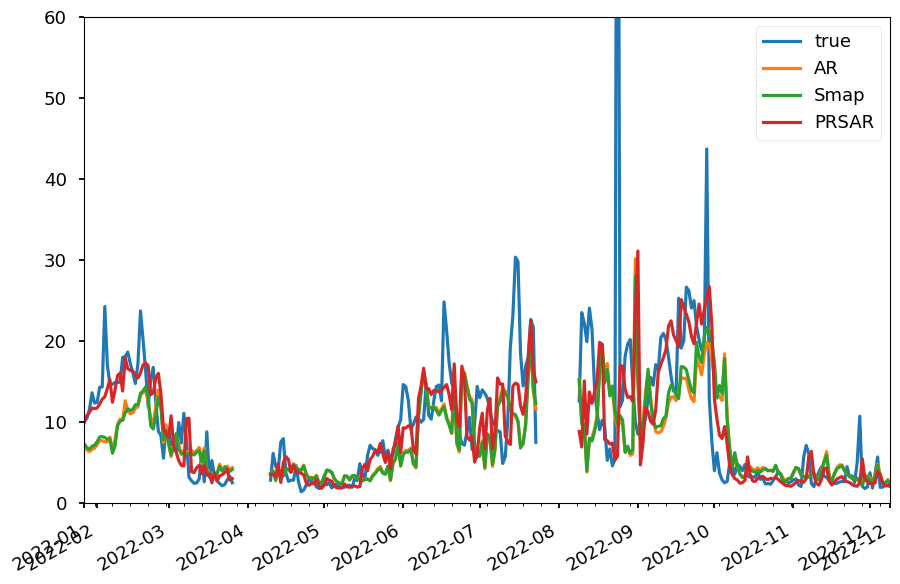

In [69]:
#df_pred.plot(y = ["true", "naive", "AR", "Smap", "PRSAR"])
df_pred.plot(y = ["true", "AR", "Smap", "PRSAR"])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.ylim(0, 60)
plt.legend()
plt.show()

## Predictions (W)

In [16]:
data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["temperature"] = data_W["temperature"].resample("1D").mean()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()
#data_W_byday["waterlevel"] = data_W["waterlevel"].resample("1D").mean()
data_W_byday["ODO"] = data_W["ODO"].resample("1D").min()
data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").max()
data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").min()
data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").max()
data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").max()

# data_W_byday = data_W[["temperature", "pH"]].resample("1D").mean()
# data_W_byday["date"] = data_W["date"].resample("1D").max()
# data_W_byday["conductivity"] = data_W["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["turbidity"] = data_W["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["ODO"] = data_W["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


In [17]:
data_W_byday = data_W_byday.dropna().resample("1D").max()

In [18]:
data_W_byday

,date,temperature,wind,ODO,salinity_max,salinity_min,log10_chlorophyll,chlorophyll
time_min,,,,,,,,
2016-03-25,2016-03-25,16.105438,3.060000,7.820000,31.4775,30.9550,0.360495,2.293480
2016-03-26,2016-03-26,15.533741,4.754167,7.125000,31.4075,27.5425,0.576452,3.770964
2016-03-27,2016-03-27,13.722917,5.606726,7.417500,31.3725,28.8325,0.518692,3.301350
2016-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-29,2016-03-29,14.414156,2.348611,7.786667,30.8775,26.2625,0.674259,4.723450
...,...,...,...,...,...,...,...,...
2022-12-27,2022-12-27,1.523598,0.682335,10.987500,31.8500,30.0550,0.437470,2.738228
2022-12-28,2022-12-28,2.451531,1.003393,11.030000,31.8800,30.1025,0.505406,3.201885
2022-12-29,2022-12-29,3.539875,1.933671,10.935000,31.8700,30.1475,0.487113,3.069820


In [19]:
def _main(data_WW_byday, is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, n_seq_warmup = 6,
          reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          #reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    # Data Preparation
    if is_log:
        array_obs = data_WW_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_WW_byday["chlorophyll"].to_numpy()

    array_datetime = data_WW_byday["date"].to_numpy()
    #array_cross = data_WW_byday[["temperature", "ODO", "salinity_max", "salinity_min", ]].to_numpy()
    array_cross = data_WW_byday[["temperature", "ODO", "salinity_max", "salinity_min", "wind", ]].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_date = []
    for cc in range(n_seq_warmup, len(list_X)):
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_date = []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))

            mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                          logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslrx.append(tmp_y_pred)

            mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

            mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslr.append(tmp_y_pred)

            tmp_y_true = list_Y[cc][tmp_index_test]
            #tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])

        list_y_true.append(tmp_list_y_true)
        list_y_pred_naive.append(tmp_list_y_pred_naive)
        list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
        list_y_pred_mslr.append(tmp_list_y_pred_mslr)
        list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
        list_y_date.append(tmp_list_y_date)

        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))

        #if cc > 5: break
        
    if is_log:
        thres = np.nanquantile(np.power(10, array_obs), thres_quantile)
    else:
        thres = np.nanquantile(array_obs, thres_quantile)

    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    
    if is_cross:
        max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)
    else:
        max_p = max(list_p_AR)
    
    dict_warmup_evaluation = dict()
    for n_seq_exclude_valid in range(n_seq_warmup, len(list_subseq)):
        
        print()
        print("n_seq_warmup =", n_seq_exclude_valid)
        
        list_res_logitcos_cross = []
        list_res_pred = []
        for start_index in range(7, 20):

            print(start_index)

            X, Y = [], []
            list_index_test_set = []
            list_date_test = []
            for cc, (tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross) in enumerate(zip(list_subseq, list_subseq_datetime, list_subseq_cross)):
                for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):
                    tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1
                    tmp_X = []
                    if is_cross:
                        for tmp_p in list_p_AR_cross:
                            tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
                    for tmp_p in list_p_AR:
                        tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
                    X.append(tmp_X)
                    Y.append([tmp_subseq[tmp_index_test]])

                    if cc >= n_seq_exclude_valid and tmp_index_right >= start_index:
                        list_index_test_set.append(len(Y) - 1)
                        list_date_test.append(tmp_subseq_datetime[tmp_index_test])

            y_true, y_pred = [], []
            y_pred_naive = []
            for tmp_index in list_index_test_set:
                lr = reg_method_func(**kargs_reg)
                #lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
                #lr = SMap(theta = 0.5)
                lr.fit(X[:tmp_index], Y[:tmp_index])
                tmp_y_pred = lr.predict([X[tmp_index]])[0]
                tmp_y_true = Y[tmp_index]
                tmp_y_pred_naive = X[tmp_index][-1]
                y_true.append(tmp_y_true)
                y_pred.append(tmp_y_pred)
                y_pred_naive.append(tmp_y_pred_naive)

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_ar, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_ar, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_ar = y_pred
            print("AR", tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
            
            y_true, y_pred = [], []
            y_pred_naive = []
            for tmp_index in list_index_test_set:
                #lr = reg_method_func(**kargs_reg)
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
                #lr = SMap(theta = 0.5)
                lr.fit(X[:tmp_index], Y[:tmp_index])
                tmp_y_pred = lr.predict([X[tmp_index]])[0]
                tmp_y_true = Y[tmp_index]
                tmp_y_pred_naive = X[tmp_index][-1]
                y_true.append(tmp_y_true)
                y_pred.append(tmp_y_pred)
                y_pred_naive.append(tmp_y_pred_naive)

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_smap, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_smap, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_smap = y_pred
            print("SMap", tmp_r2_smap, tmp_r2_naive, tmp_rocauc_smap, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslrx, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslrx, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslrx = y_pred
            print("MSLRX", tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslrxsolu3[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslrxsolu3, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslrxsolu3, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslrxsolu3 = y_pred
            print("MXLRXSolu3", tmp_r2_mslrxsolu3, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslr, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslr, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslr = y_pred
            print("MSLR", tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)

            list_res_logitcos_cross.append((tmp_r2_naive, tmp_rocauc_naive,
                                            tmp_r2_ar, tmp_rocauc_ar, 
                                            tmp_r2_smap, tmp_rocauc_smap,
                                            tmp_r2_mslrx, tmp_rocauc_mslrx, 
                                            tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, 
                                            tmp_r2_mslr, tmp_rocauc_mslr,
                                           ))
            
            list_res_pred.append((list_date_test, y_true, y_pred_naive, y_pred_ar, y_pred_smap, y_pred_mslrx, y_pred_mslrxsolu3, y_pred_mslr))
            
        dict_warmup_evaluation[n_seq_exclude_valid] = (list_res_logitcos_cross, list_res_pred)
                
    return dict_warmup_evaluation


In [79]:

dict_setting_results = dict()
for is_log in [False]:
    for is_cross in [True, False]:
        for is_phase in [True]:
            for horizon_forecast in [1, 3, 7]:
                
                #tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearSVR", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("================================================")
                
                dict_setting_results[tmp_setting] = _main(data_W_byday, n_seq_warmup=1, 
                                                          reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                                          #reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                                          is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast,)
                 
                



setting = (True, True, True, 1, 'LinearRegression')
Subseqs:
	 0 2016-04-19 2016-05-10 23
	 1 2016-06-07 2016-06-30 25
	 2 2016-07-19 2016-08-13 27
	 3 2016-08-31 2016-11-23 86
	 4 2017-04-06 2017-05-11 37
	 5 2017-06-16 2017-07-13 29
	 6 2017-07-19 2017-08-08 22
	 7 2017-09-13 2017-10-19 38
	 8 2017-11-01 2017-12-10 41
	 9 2018-01-26 2018-02-22 29
	 10 2018-04-10 2018-06-15 68
	 11 2019-02-05 2019-03-12 37
	 12 2019-03-21 2019-04-17 29
	 13 2019-04-25 2019-05-21 28
	 14 2019-05-24 2019-07-25 64
	 15 2019-08-01 2019-09-02 34
	 16 2019-09-06 2019-09-27 23
	 17 2020-04-15 2020-05-04 21
	 18 2020-12-12 2021-01-27 48
	 19 2021-03-26 2021-08-05 134
	 20 2021-08-13 2021-12-01 112
	 21 2021-12-16 2022-10-23 313
	 22 2022-10-26 2022-12-31 68



C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:36.054245
seq 2 finished 0:01:37.275525


C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_7220\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \

KeyboardInterrupt



In [ ]:

with open(r"res/res_vimsw_pred_0202_1.csv", "w") as fw:
    
    head = ["is_log10", "is_cross", "is_phase", "horizon_forecast", "reg_method", "n_seq_warmup", "len_warmup", "r2_naive", "rocauc_naive", "r2_ar", "rocauc_ar", "r2_smap", 
            "rocauc_smap", "r2_mslrx", "rocauc_mslrx", "tmp_r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3", "tmp_r2_mslr", "tmp_rocauc_mslr", ]
    fw.write(",".join(head) + "\n")

    for tmp_setting in dict_setting_results:

        is_log, is_cross, is_phase, horizon_forecast, reg_method = tmp_setting
        dict_warmup_evaluation = dict_setting_results[tmp_setting]

        for n_seq_warmup in dict_warmup_evaluation:
            
            for cc in range(len(dict_warmup_evaluation[n_seq_warmup])):
                
                len_warmup = cc + 7
                tmp_r2_naive, tmp_rocauc_naive, tmp_r2_ar, tmp_rocauc_ar, tmp_r2_smap, tmp_rocauc_smap, tmp_r2_mslrx, tmp_rocauc_mslrx, tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, tmp_r2_mslr, tmp_rocauc_mslr = dict_warmup_evaluation[n_seq_warmup][cc]
            
                line = [is_log, is_cross, is_phase, horizon_forecast, reg_method, n_seq_warmup, len_warmup, tmp_r2_naive, tmp_rocauc_naive, tmp_r2_ar, tmp_rocauc_ar, tmp_r2_smap, tmp_rocauc_smap, tmp_r2_mslrx, tmp_rocauc_mslrx, tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, tmp_r2_mslr, tmp_rocauc_mslr]
                fw.write(",".join([str(i) for i in line]) + "\n")

    

## Predictions (WW) - save prediction results

In [51]:
data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


In [52]:
data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])


In [53]:
data_WW_byday = data_WW_byday.dropna().resample("1D").max()

In [54]:
data_WW_byday

,date,conductivity,turbidity,temperature,pH,ODO,salinity_max,salinity_min,log10_chlorophyll,chlorophyll,wind
time_min,,,,,,,,,,,
2018-10-12,2018-10-12,46.978,47.06,24.194146,7.902439,5.84,30.55,28.48,1.295567,19.75,2.774167
2018-10-13,2018-10-13,46.748,29.83,22.100917,7.863437,5.89,30.41,28.41,1.480438,30.23,2.256528
2018-10-14,2018-10-14,46.615,18.17,20.642937,7.871354,6.06,30.33,28.59,1.342620,22.01,1.743472
2018-10-15,2018-10-15,46.385,15.75,21.330021,7.870104,6.32,30.16,28.72,1.330008,21.38,4.257870
2018-10-16,2018-10-16,46.521,18.81,21.417677,7.843646,5.63,30.26,28.59,1.221675,16.66,2.117500
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,2022-12-20,49.115,5.79,5.802531,7.942708,9.53,31.56,28.73,0.429752,2.69,1.510417
2022-12-21,2022-12-21,49.668,9.33,5.474958,7.948021,9.63,31.91,29.18,0.459392,2.88,2.171071
2022-12-22,2022-12-22,49.776,50.00,5.977583,7.944375,9.74,32.03,29.50,0.563481,3.66,4.545590


In [55]:
def _main(data_WW_byday, is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, n_seq_warmup = 6, is_mslr = True, is_smap_cv = False,
          reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          #reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    # Data Preparation
    if is_log:
        array_obs = data_WW_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_WW_byday["chlorophyll"].to_numpy()

    array_datetime = data_WW_byday["date"].to_numpy()
    array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature"]].to_numpy()
    #array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [56]:

dict_setting_results = dict()
for is_log in [True, ]:
    for is_cross in [True, False]:
        for is_phase in [True]:
            for horizon_forecast in [1, 3, 7]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast,
                                  is_mslr = False)
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                #tail_max = "_2ndmax"
                tail_max = ""
                
                #fname_write = "vimsWW_nowind% s_pred_% s_% s% s% s.csv" % (tail_max, tail_method, tail_horizon, tail_cross, tail_log, )
                fname_write = "vimsWW_nowind% s_pred_nomslr_% s_% s% s% s.csv" % (tail_max, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2022-07-28 2022-12-09 136

seq 1 finished 0:00:00.352450
seq 2 finished 0:00:01.405136
seq 3 finished 0:00:01.765253
seq 4 finished 0:00:03.795974
seq 5 finished 0:00:05.781571
seq 6 finished 0:00:06.832472
seq 7 finished 0:00:10.349349
seq 8 finished 0:00:10.943371
seq 9 finished 0:00:11.855655
seq 10 finished 0:00:15.333658
seq 11 finished 0:00:16.010990
seq 12 finished 0:00:17.538334
seq 13 finished 0:00:20.213348
seq 14 fi

## Predictions (W) - save prediction results

In [18]:

data_W_byday = data_W[["temperature", "wind"]].resample("1D").mean()
data_W_byday["date"] = data_W["date"].resample("1D").max()
data_W_byday["ODO"] = data_W["ODO"].resample("1D").min()
data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").max()
data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").min()
data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").max()
data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").max()

# data_W_byday = data_W[["temperature", "wind"]].resample("1D").mean()
# data_W_byday["date"] = data_W["date"].resample("1D").max()
# data_W_byday["ODO"] = data_W["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_max"] = data_W["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["salinity_min"] = data_W["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["log10_chlorophyll"] = data_W["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_W_byday["chlorophyll"] = data_W["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


In [19]:
data_W_byday = data_W_byday.dropna().resample("1D").max()

In [20]:
data_W_byday

,temperature,wind,date,ODO,salinity_max,salinity_min,log10_chlorophyll,chlorophyll
time_min,,,,,,,,
2016-03-25,16.105438,3.060000,2016-03-25,7.820000,31.4775,30.9550,0.360495,2.293480
2016-03-26,15.533741,4.754167,2016-03-26,7.125000,31.4075,27.5425,0.576452,3.770964
2016-03-27,13.722917,5.606726,2016-03-27,7.417500,31.3725,28.8325,0.518692,3.301350
2016-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-29,14.414156,2.348611,2016-03-29,7.786667,30.8775,26.2625,0.674259,4.723450
...,...,...,...,...,...,...,...,...
2022-12-27,1.523598,0.682335,2022-12-27,10.987500,31.8500,30.0550,0.437470,2.738228
2022-12-28,2.451531,1.003393,2022-12-28,11.030000,31.8800,30.1025,0.505406,3.201885
2022-12-29,3.539875,1.933671,2022-12-29,10.935000,31.8700,30.1475,0.487113,3.069820


In [21]:
def _main(data_WW_byday, is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, n_seq_warmup = 6, is_mslr = True, is_smap_cv = False,
          reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          #reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    # Data Preparation
    if is_log:
        array_obs = data_WW_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_WW_byday["chlorophyll"].to_numpy()

    array_datetime = data_WW_byday["date"].to_numpy()
    array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "temperature"]].to_numpy()
    #array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "temperature", "wind"]].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [22]:

dict_setting_results = dict()
for is_log in [True, ]:
    for is_cross in [True, False]:
        for is_phase in [True]:
            for horizon_forecast in [1, 3, 7]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("================================================")
                
                tmp_res_df = _main(data_W_byday, n_seq_warmup=1, 
                                                          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                                          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                                          is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast,)
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                # tail_max = "_2ndmax"
                tail_max = ""
                
                fname_write = "vimsW_nowind% s_pred_% s_% s% s% s.csv" % (tail_max, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsW_pred", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
Subseqs:
	 0 2016-04-19 2016-05-10 23
	 1 2016-06-07 2016-06-30 25
	 2 2016-07-19 2016-08-13 27
	 3 2016-08-31 2016-11-23 86
	 4 2017-04-06 2017-05-11 37
	 5 2017-06-16 2017-07-13 29
	 6 2017-07-19 2017-08-08 22
	 7 2017-09-13 2017-10-19 38
	 8 2017-11-01 2017-12-10 41
	 9 2018-01-26 2018-02-22 29
	 10 2018-04-10 2018-06-15 68
	 11 2019-02-05 2019-03-12 37
	 12 2019-03-21 2019-04-17 29
	 13 2019-04-25 2019-05-21 28
	 14 2019-05-24 2019-07-25 64
	 15 2019-08-01 2019-09-02 34
	 16 2019-09-06 2019-09-27 23
	 17 2020-04-15 2020-05-04 21
	 18 2020-12-12 2021-01-27 48
	 19 2021-03-26 2021-08-05 134
	 20 2021-08-13 2021-12-01 112
	 21 2021-12-16 2022-10-23 313
	 22 2022-10-26 2022-12-31 68



C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:25.254444


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:01:01.154054


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 3 finished 0:04:04.113335
seq 4 finished 0:05:27.712874
seq 5 finished 0:06:34.824332
seq 6 finished 0:07:28.841173
seq 7 finished 0:09:23.029433
seq 8 finished 0:11:42.471635
seq 9 finished 0:13:22.075309
seq 10 finished 0:18:19.083575
seq 11 finished 0:20:52.150667
seq 12 finished 0:22:50.108123
seq 13 finished 0:24:56.779205
seq 14 finished 0:31:05.820067
seq 15 finished 0:34:19.584908
seq 16 finished 0:36:18.969797
seq 17 finished 0:38:06.763568
seq 18 finished 0:43:32.314698
seq 19 finished 1:01:47.329795
seq 20 finished 1:16:44.705790
seq 21 finished 2:06:07.714790
seq 22 finished 2:18:03.740259

setting = (True, True, True, 3, 'LinearRegression')
Subseqs:
	 0 2016-04-19 2016-05-10 23
	 1 2016-06-07 2016-06-30 25
	 2 2016-07-19 2016-08-13 27
	 3 2016-08-31 2016-11-23 86
	 4 2017-04-06 2017-05-11 37
	 5 2017-06-16 2017-07-13 29
	 6 2017-07-19 2017-08-08 22
	 7 2017-09-13 2017-10-19 38
	 8 2017-11-01 2017-12-10 41
	 9 2018-01-26 2018-02-22 29
	 10 2018-04-10 2018-06-15 68
	 11 

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:16.834295


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:00:47.416029


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 3 finished 0:03:53.185307
seq 4 finished 0:05:16.731505
seq 5 finished 0:06:19.905136
seq 6 finished 0:07:04.598812
seq 7 finished 0:09:00.568117
seq 8 finished 0:11:22.030448
seq 9 finished 0:12:54.349543
seq 10 finished 0:17:56.793818
seq 11 finished 0:20:25.151456
seq 12 finished 0:22:15.060438
seq 13 finished 0:24:06.751894
seq 14 finished 0:30:15.417364
seq 15 finished 0:33:16.359239
seq 16 finished 0:35:01.491354
seq 17 finished 0:36:30.930954
seq 18 finished 0:41:31.608727
seq 19 finished 0:58:51.769747
seq 20 finished 1:13:49.873692
seq 21 finished 2:08:14.169144
seq 22 finished 2:21:11.861949

setting = (True, True, True, 7, 'LinearRegression')
Subseqs:
	 0 2016-04-19 2016-05-10 23
	 1 2016-06-07 2016-06-30 25
	 2 2016-07-19 2016-08-13 27
	 3 2016-08-31 2016-11-23 86
	 4 2017-04-06 2017-05-11 37
	 5 2017-06-16 2017-07-13 29
	 6 2017-07-19 2017-08-08 22
	 7 2017-09-13 2017-10-19 38
	 8 2017-11-01 2017-12-10 41
	 9 2018-01-26 2018-02-22 29
	 10 2018-04-10 2018-06-15 68
	 11 

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\1702449697.py:114: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(self.transmat_[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\1702449697.py:127: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(self.transmat_[ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\1702449697.py:114: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(self.transmat_[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\1702449697.py:127: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii

seq 1 finished 0:00:11.491435
seq 2 finished 0:00:28.847349


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 3 finished 0:03:13.612917
seq 4 finished 0:04:21.494324
seq 5 finished 0:05:11.532312
seq 6 finished 0:05:42.586321
seq 7 finished 0:07:10.991061
seq 8 finished 0:09:00.295030
seq 9 finished 0:10:09.217599
seq 10 finished 0:14:23.470219
seq 11 finished 0:16:17.844219
seq 12 finished 0:17:39.592395
seq 13 finished 0:18:59.547241
seq 14 finished 0:23:49.836075
seq 15 finished 0:26:04.537639
seq 16 finished 0:27:09.506533
seq 17 finished 0:28:02.408243
seq 18 finished 0:32:05.386780
seq 19 finished 0:47:34.615449
seq 20 finished 1:01:51.182461
seq 21 finished 1:54:31.298903
seq 22 finished 2:05:35.115973

setting = (True, False, True, 1, 'LinearRegression')
Subseqs:
	 0 2016-04-19 2016-05-10 23
	 1 2016-06-07 2016-06-30 25
	 2 2016-07-19 2016-08-13 27
	 3 2016-08-31 2016-11-23 86
	 4 2017-04-06 2017-05-11 37
	 5 2017-06-16 2017-07-13 29
	 6 2017-07-19 2017-08-08 22
	 7 2017-09-13 2017-10-19 38
	 8 2017-11-01 2017-12-10 41
	 9 2018-01-26 2018-02-22 29
	 10 2018-04-10 2018-06-15 68
	 11

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:23.808111


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:00:57.218190
seq 3 finished 0:04:18.193455
seq 4 finished 0:05:51.448390
seq 5 finished 0:07:07.012498
seq 6 finished 0:08:05.782806
seq 7 finished 0:10:10.931941
seq 8 finished 0:12:38.251258
seq 9 finished 0:14:15.427816
seq 10 finished 0:18:55.637492
seq 11 finished 0:21:28.065911
seq 12 finished 0:23:27.006096
seq 13 finished 0:25:24.114203
seq 14 finished 0:31:08.311611
seq 15 finished 0:34:12.365585
seq 16 finished 0:36:05.320210
seq 17 finished 0:37:44.015173
seq 18 finished 0:42:42.875240
seq 19 finished 0:59:20.243506
seq 20 finished 1:13:42.487688
seq 21 finished 2:04:01.656441
seq 22 finished 2:15:56.462444

setting = (True, False, True, 3, 'LinearRegression')
Subseqs:
	 0 2016-04-19 2016-05-10 23
	 1 2016-06-07 2016-06-30 25
	 2 2016-07-19 2016-08-13 27
	 3 2016-08-31 2016-11-23 86
	 4 2017-04-06 2017-05-11 37
	 5 2017-06-16 2017-07-13 29
	 6 2017-07-19 2017-08-08 22
	 7 2017-09-13 2017-10-19 38
	 8 2017-11-01 2017-12-10 41
	 9 2018-01-26 2018-02-22 29
	 10

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:15.656001


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:00:43.189001


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 3 finished 0:03:48.321001
seq 4 finished 0:05:14.957001
seq 5 finished 0:06:16.809000
seq 6 finished 0:07:01.331000
seq 7 finished 0:08:48.120000
seq 8 finished 0:11:03.763000
seq 9 finished 0:12:31.426001
seq 10 finished 0:17:15.268999
seq 11 finished 0:19:33.345000
seq 12 finished 0:21:17.525000
seq 13 finished 0:23:01.455002
seq 14 finished 0:28:33.128018
seq 15 finished 0:31:15.575018
seq 16 finished 0:32:50.942018
seq 17 finished 0:34:14.373020
seq 18 finished 0:38:49.707018
seq 19 finished 0:55:10.944018
seq 20 finished 1:09:45.332082
seq 21 finished 2:00:19.829081
seq 22 finished 2:11:56.786081

setting = (True, False, True, 7, 'LinearRegression')
Subseqs:
	 0 2016-04-19 2016-05-10 23
	 1 2016-06-07 2016-06-30 25
	 2 2016-07-19 2016-08-13 27
	 3 2016-08-31 2016-11-23 86
	 4 2017-04-06 2017-05-11 37
	 5 2017-06-16 2017-07-13 29
	 6 2017-07-19 2017-08-08 22
	 7 2017-09-13 2017-10-19 38
	 8 2017-11-01 2017-12-10 41
	 9 2018-01-26 2018-02-22 29
	 10 2018-04-10 2018-06-15 68
	 11

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:10.724999
seq 2 finished 0:00:28.434998


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 3 finished 0:03:12.290999
seq 4 finished 0:04:20.625999
seq 5 finished 0:05:11.041999
seq 6 finished 0:05:41.196999
seq 7 finished 0:07:12.111000
seq 8 finished 0:08:59.730999
seq 9 finished 0:10:06.414001
seq 10 finished 0:14:08.705000
seq 11 finished 0:15:55.425000
seq 12 finished 0:17:11.337999
seq 13 finished 0:18:26.458998
seq 14 finished 0:23:09.188000
seq 15 finished 0:25:15.689998
seq 16 finished 0:26:17.768999
seq 17 finished 0:27:08.583001
seq 18 finished 0:30:57.173000
seq 19 finished 0:45:54.857999
seq 20 finished 0:59:29.416999
seq 21 finished 1:42:53.645000
seq 22 finished 1:50:00.865001


## Predictions (WW) - save prediction results - feature importance

In [13]:

# # 1stmax
# data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
# data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
# data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# # 2ndmax
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)

# # 90-quantile
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)

# # 50-quantile
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.7) if len(x) >= 2 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.3) if len(x) >= 2 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)


In [13]:
# # Smoothed
# data_WW_smooth = data_WW.copy()
# data_WW_smooth["datetime"] = data_WW_smooth.index
# data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
# data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

# # regularize_coef, max_rate = 5, 100    # Smooth 4
# # regularize_coef, max_rate = 5, 50    # Smooth 7
# regularize_coef, max_rate = 10, 100    # Smooth 9

# data_WW_smooth["log_chlorophyll_p5"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(x + regularize_coef))

# while True:
    
#     data_WW_smooth_diff = data_WW_smooth.diff()
#     data_WW_smooth["chl_rate_regularized"] = data_WW_smooth_diff["log_chlorophyll_p5"] / data_WW_smooth_diff["datetime"].map(lambda x: x.value / (10 ** 9) / (3600 * 24)).fillna(0.)
#     data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.
    
#     data_WW_smooth["chl_rate_regularized"].hist(bins = 50)
#     plt.show()
    
#     data_WW_smooth["chlorophyll"] = data_WW_smooth.apply(lambda x: x["chlorophyll"] if x["chl_rate_regularized"] < max_rate else np.nan, axis = 1)
    
#     if data_WW_smooth.isnull().any().any():
#         data_WW_smooth = data_WW_smooth.dropna()
#     else:
#         break
        
# data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
# data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
# data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
# data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
# data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
# data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
# data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
# data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)


In [17]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "1day", '1day', 2, 1   # smoothtrim1 untrimmed
# forward_period, backward_period, n_std, offset_std = "1day", '1day', 5, 1   # smoothtrim3 untrimmed
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 5, 1   # smoothtrim5 untrimmed
# forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 5, 1   # smoothtrim7 untrimmed
# forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 3, 1   # smoothtrim11 trimmed
# forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 2, 1   # smoothtrim13 trimmed
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 3, 1   # smoothtrim15 trimmed


data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)


In [18]:
data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])


In [19]:
data_WW_byday = data_WW_byday.dropna().resample("1D").max()

In [20]:
data_WW_byday

,date,conductivity,turbidity,temperature,pH,ODO,salinity_max,salinity_min,chlorophyll,log10_chlorophyll,wind
time_min,,,,,,,,,,,
2019-01-17,2019-01-17,41.905,9.27,4.320865,8.138333,11.25,26.27,20.51,15.87,1.200577,2.467619
2019-01-18,2019-01-18,44.612,14.14,4.865563,8.160833,11.20,28.22,20.78,17.65,1.246745,1.048043
2019-01-19,2019-01-19,44.860,19.43,5.435183,8.180538,11.01,28.47,21.08,22.15,1.345374,3.542546
2019-01-20,2019-01-20,45.246,37.77,6.792628,8.144468,10.45,28.87,21.02,22.03,1.343014,4.180476
2019-01-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,2022-12-20,49.115,5.79,5.802531,7.942708,9.53,31.56,28.73,2.69,0.429752,1.510417
2022-12-21,2022-12-21,49.668,9.33,5.474958,7.948021,9.63,31.91,29.18,2.88,0.459392,2.171071
2022-12-22,2022-12-22,49.776,50.00,5.977583,7.944375,9.74,32.03,29.50,3.66,0.563481,4.545590


In [28]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(max(5, horizon_forecast + 2), len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [22]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                tail_max = "smoothtrim1"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:22.983999
seq 2 finished 0:01:00.654000
seq 3 finished 0:01:54.970999
seq 4 finished 0:02:47.281000
seq 5 finished 0:03:51.700000
seq 6 finished 0:04:35.999999
seq 7 finished 0:05:17.587999
seq 8 finished 0:10:21.039662
seq 9 finished 0:11:23.598881
seq 10 finished 0:15:15.630373
seq 11 finished 0:17:34.061324
seq 12 finished 0:24:06.137989
seq 13 finished 0:36:22.501318
seq 14 finished 0:46:39.482729
seq 15 finished 0:

In [23]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "1day", '1day', 5, 1   # smoothtrim3

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [24]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim1"
                tail_max = "smoothtrim3"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:16.827274
seq 2 finished 0:00:44.246370
seq 3 finished 0:01:22.148187
seq 4 finished 0:01:59.320341
seq 5 finished 0:02:44.738539
seq 6 finished 0:03:15.453765
seq 7 finished 0:03:44.068386
seq 8 finished 0:07:02.980817
seq 9 finished 0:07:44.018761
seq 10 finished 0:10:08.392084
seq 11 finished 0:11:36.309495
seq 12 finished 0:15:27.881718
seq 13 finished 0:23:13.382664
seq 14 finished 0:29:53.698987
seq 15 finished 0:

In [25]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 5, 1   # smoothtrim5

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [26]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim1"
                # tail_max = "smoothtrim3"
                tail_max = "smoothtrim5"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:20.490758
seq 2 finished 0:00:54.764329
seq 3 finished 0:01:43.117848
seq 4 finished 0:02:33.485528
seq 5 finished 0:03:37.390156
seq 6 finished 0:04:20.355569
seq 7 finished 0:05:02.199191
seq 8 finished 0:09:57.337855
seq 9 finished 0:10:58.914668
seq 10 finished 0:14:39.982531
seq 11 finished 0:17:09.008490
seq 12 finished 0:23:38.074781
seq 13 finished 0:36:47.564207
seq 14 finished 0:48:17.671193
seq 15 finished 0:

In [27]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 5, 1   # smoothtrim7

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [28]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim1"
                # tail_max = "smoothtrim3"
                # tail_max = "smoothtrim5"
                tail_max = "smoothtrim7"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:20.617922
seq 2 finished 0:00:55.634794
seq 3 finished 0:01:44.660767
seq 4 finished 0:02:36.349165
seq 5 finished 0:03:41.927022
seq 6 finished 0:04:25.671662
seq 7 finished 0:05:09.104910
seq 8 finished 0:10:10.676679
seq 9 finished 0:11:12.229654
seq 10 finished 0:14:48.329639
seq 11 finished 0:17:05.107363
seq 12 finished 0:23:12.992375
seq 13 finished 0:35:28.403793
seq 14 finished 0:45:53.114001
seq 15 finished 0:

In [29]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 3, 1   # smoothtrim11

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    # tmp_trimmed_mean = np.mean(tmp_neighbors)
    # tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [30]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim1"
                # tail_max = "smoothtrim3"
                # tail_max = "smoothtrim5"
                tail_max = "smoothtrim11"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:18.706896
seq 2 finished 0:00:52.260452
seq 3 finished 0:01:43.832893
seq 4 finished 0:02:36.120291
seq 5 finished 0:03:40.338957
seq 6 finished 0:04:24.155659
seq 7 finished 0:05:06.185771
seq 8 finished 0:09:59.072740
seq 9 finished 0:11:02.639240
seq 10 finished 0:14:52.108929
seq 11 finished 0:17:09.853436
seq 12 finished 0:23:00.779435
seq 13 finished 0:35:15.239724
seq 14 finished 0:45:57.383690
seq 15 finished 0:

In [31]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 2, 1   # smoothtrim13

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    # tmp_trimmed_mean = np.mean(tmp_neighbors)
    # tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [32]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim1"
                # tail_max = "smoothtrim3"
                # tail_max = "smoothtrim5"
                tail_max = "smoothtrim13"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:23.702416
seq 2 finished 0:01:00.304707
seq 3 finished 0:01:53.154689
seq 4 finished 0:02:44.205966
seq 5 finished 0:03:46.951021
seq 6 finished 0:04:30.678792
seq 7 finished 0:05:11.896907
seq 8 finished 0:10:16.870694
seq 9 finished 0:11:19.657064
seq 10 finished 0:14:59.323492
seq 11 finished 0:17:13.170489
seq 12 finished 0:23:26.992696
seq 13 finished 0:35:54.800536
seq 14 finished 0:46:33.515025
seq 15 finished 0:

In [33]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 3, 1   # smoothtrim15 trimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    # tmp_trimmed_mean = np.mean(tmp_neighbors)
    # tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 268


In [34]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim1"
                # tail_max = "smoothtrim3"
                # tail_max = "smoothtrim5"
                tail_max = "smoothtrim15"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:19.108662
seq 2 finished 0:00:53.066182
seq 3 finished 0:01:43.443230
seq 4 finished 0:02:35.192493
seq 5 finished 0:03:40.407846
seq 6 finished 0:04:24.747522
seq 7 finished 0:05:05.412389
seq 8 finished 0:09:53.578174
seq 9 finished 0:10:54.076676
seq 10 finished 0:14:30.804322
seq 11 finished 0:16:40.496759
seq 12 finished 0:22:22.509841
seq 13 finished 0:33:54.143442
seq 14 finished 0:44:09.906183
seq 15 finished 0:

In [35]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 5, 1   # smoothtrim17 trimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    # tmp_trimmed_mean = np.mean(tmp_neighbors)
    # tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 113


In [36]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim1"
                # tail_max = "smoothtrim3"
                # tail_max = "smoothtrim5"
                tail_max = "smoothtrim17"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:21.039471
seq 2 finished 0:00:57.637944
seq 3 finished 0:01:47.340181
seq 4 finished 0:02:40.683128
seq 5 finished 0:03:49.623814
seq 6 finished 0:04:38.948961
seq 7 finished 0:05:23.374452
seq 8 finished 0:10:28.168377
seq 9 finished 0:11:29.268378
seq 10 finished 0:15:17.377099
seq 11 finished 0:17:36.497499
seq 12 finished 0:23:39.332684
seq 13 finished 0:36:08.023925
seq 14 finished 0:46:46.376666
seq 15 finished 0:

In [37]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "2hour", '2hour', 1, 1, 1, True   # smoothmeanstd2

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 68


In [38]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd2"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:26.187763
seq 2 finished 0:01:05.114904
seq 3 finished 0:01:57.885407
seq 4 finished 0:02:53.975062
seq 5 finished 0:04:01.969949
seq 6 finished 0:04:52.167075
seq 7 finished 0:05:38.398534
seq 8 finished 0:10:56.723459
seq 9 finished 0:12:00.122675
seq 10 finished 0:15:45.176722
seq 11 finished 0:18:00.597652
seq 12 finished 0:23:56.656071
seq 13 finished 0:35:44.851257
seq 14 finished 0:45:46.463518
seq 15 finished 0:

In [39]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "2hour", '2hour', 2, 1, 1, False   # smoothmeanstd4

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 17


In [40]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd4"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:20.800673
seq 2 finished 0:00:55.536045
seq 3 finished 0:01:43.464632
seq 4 finished 0:02:35.063685
seq 5 finished 0:03:41.572605
seq 6 finished 0:04:26.729627
seq 7 finished 0:05:10.631412
seq 8 finished 0:10:09.899579
seq 9 finished 0:11:11.909105
seq 10 finished 0:14:56.152976
seq 11 finished 0:17:18.107630
seq 12 finished 0:23:30.057191
seq 13 finished 0:35:48.660406
seq 14 finished 0:46:31.375840
seq 15 finished 0:

In [44]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "1hour", '1hour', 2, 1, 1, False   # smoothmeanstd6

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 7


In [45]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd6"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:22.456228
seq 2 finished 0:00:59.457664
seq 3 finished 0:01:50.375246
seq 4 finished 0:02:45.121771
seq 5 finished 0:03:54.551492
seq 6 finished 0:04:40.954488
seq 7 finished 0:05:25.942011
seq 8 finished 0:10:38.235960
seq 9 finished 0:11:44.163712
seq 10 finished 0:15:40.544546
seq 11 finished 0:18:00.260923
seq 12 finished 0:24:08.732085
seq 13 finished 0:36:28.308849
seq 14 finished 0:46:35.575423
seq 15 finished 0:

In [46]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "12hour", '12hour', 3, 3, 1, False   # smoothmeanstd8

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 13


In [47]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd8"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:21.509997
seq 2 finished 0:00:56.624998
seq 3 finished 0:01:46.234997
seq 4 finished 0:02:38.601996
seq 5 finished 0:03:42.685997
seq 6 finished 0:04:25.997997
seq 7 finished 0:05:09.040997
seq 8 finished 0:10:01.578998
seq 9 finished 0:11:03.330997
seq 10 finished 0:14:41.393997
seq 11 finished 0:16:55.006997
seq 12 finished 0:22:50.953998
seq 13 finished 0:34:38.089999
seq 14 finished 0:44:29.510997
seq 15 finished 0:

In [48]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "12hour", '12hour', 3, 3, 1, True   # smoothmeanstd10

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 35


In [49]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd10"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:21.231000
seq 2 finished 0:00:56.364000
seq 3 finished 0:01:45.115000
seq 4 finished 0:02:37.126000
seq 5 finished 0:03:41.719000
seq 6 finished 0:04:25.985000
seq 7 finished 0:05:06.246001
seq 8 finished 0:09:56.890002
seq 9 finished 0:10:56.973002
seq 10 finished 0:14:35.698001
seq 11 finished 0:16:49.483000
seq 12 finished 0:22:43.745002
seq 13 finished 0:34:25.033000
seq 14 finished 0:44:15.591001
seq 15 finished 0:

In [50]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "24hour", '24hour', 3, 3, 1, True   # smoothmeanstd12

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 53


In [51]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd12"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:20.825000
seq 2 finished 0:00:55.651001
seq 3 finished 0:01:44.458999
seq 4 finished 0:02:35.435000
seq 5 finished 0:03:39.347000
seq 6 finished 0:04:25.592999
seq 7 finished 0:05:06.679999
seq 8 finished 0:09:56.418999
seq 9 finished 0:10:57.228000
seq 10 finished 0:14:33.478000
seq 11 finished 0:16:46.704999
seq 12 finished 0:22:40.650999
seq 13 finished 0:34:21.116999
seq 14 finished 0:44:09.273999
seq 15 finished 0:

In [26]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "24hour", '0hour', 3, 3, 1, True   # smoothmeanstd14

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 57


In [29]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, False]:
    for horizon_forecast in [1, 2, 3, 4, 5, 6, 7]:
    # for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                if is_cross:
                    tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                else:
                    tail_removed_features = "noX" 
                
                tail_max = "smoothmeanstd14"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:18.321187
seq 2 finished 0:00:50.087989
seq 3 finished 0:01:30.753000
seq 4 finished 0:02:14.069952
seq 5 finished 0:03:07.596539
seq 6 finished 0:03:43.641185
seq 7 finished 0:04:15.248055
seq 8 finished 0:07:55.979412
seq 9 finished 0:08:42.485040
seq 10 finished 0:11:30.969178
seq 11 finished 0:13:12.510494
seq 12 finished 0:17:48.930363
seq 13 finished 0:26:03.540041
seq 14 finished 0:32:37.768038
seq 15 finished 0:

In [39]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [41]:

is_log = True
is_phase = True

dict_setting_results = dict()

#for is_cross in [True, False]:
for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_featureimportance", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2022-07-28 2022-12-09 136

seq 1 finished 0:01:52.442128
seq 2 finished 0:06:00.666128
seq 3 finished 0:07:28.180129
seq 4 finished 0:14:39.784129
seq 5 finished 0:21:44.321128
seq 6 finished 0:25:36.334425
seq 7 finished 0:38:03.194271
seq 8 finished 0:40:10.260323
seq 9 finished 0:42:59.426063
seq 10 finished 0:54:57.182838
seq 11 finished 0:57:05.765315
seq 12 finished 1:01:04.069411
seq 13 finished 1

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \


seq 1 finished 0:01:42.398418
seq 2 finished 0:05:50.248757
seq 3 finished 0:07:16.461087
seq 4 finished 0:15:02.295386
seq 5 finished 0:22:08.263661
seq 6 finished 0:25:41.754288
seq 7 finished 0:37:22.236379
seq 8 finished 0:39:08.693817
seq 9 finished 0:41:38.603885
seq 10 finished 0:53:10.503587
seq 11 finished 0:55:08.827586
seq 12 finished 0:59:12.031354
seq 13 finished 1:06:50.179482
seq 14 finished 1:16:25.299079
seq 15 finished 1:27:51.872170
seq 16 finished 1:49:23.132211
seq 17 finished 2:17:08.876158

setting = (True, True, True, 3, 'LinearRegression')
removed feature = ODO
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:19.956000
seq 2 finished 0:04:52.112000
seq 3 finished 0:05:47.617001
seq 4 finished 0:11:44.593999


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 5 finished 0:17:19.493998
seq 6 finished 0:20:00.689676
seq 7 finished 0:29:46.726580
seq 8 finished 0:30:53.728914
seq 9 finished 0:32:36.099064
seq 10 finished 0:42:00.435286
seq 11 finished 0:43:10.658603
seq 12 finished 0:46:06.360493
seq 13 finished 0:52:01.806059
seq 14 finished 0:59:35.071750
seq 15 finished 1:08:33.623802
seq 16 finished 1:25:32.253184
seq 17 finished 1:46:17.152252

setting = (True, True, True, 7, 'LinearRegression')
removed feature = salinity_max
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:17.776001
seq 2 finished 0:04:56.873604
seq 3 finished 0:05:53.222603
seq 4 finished 0:11:57.582606


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 5 finished 0:17:58.413632
seq 6 finished 0:20:48.122220
seq 7 finished 0:30:54.010039
seq 8 finished 0:32:01.509914
seq 9 finished 0:33:45.820692
seq 10 finished 0:43:16.928177
seq 11 finished 0:44:27.647109
seq 12 finished 0:47:23.372179
seq 13 finished 0:53:15.015055
seq 14 finished 1:00:50.509716
seq 15 finished 1:09:50.760955
seq 16 finished 1:26:58.172900
seq 17 finished 1:48:43.236270

setting = (True, True, True, 7, 'LinearRegression')
removed feature = salinity_min
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:20.402776
seq 2 finished 0:05:00.496432
seq 3 finished 0:05:57.899304
seq 4 finished 0:11:47.308038
seq 5 finished 0:17:48.536616
seq 6 finished 0:20:36.294551
seq 7 finished 0:30:26.127721
seq 8 finished 0:31:32.595582
seq 9 finished 0:33:14.515554
seq 10 finished 0:42:41.034998
seq 11 finished 0:43:50.237224
seq 12 finished 0:46:44.188989
seq 13 finished 0:52:39.217650
seq 14 finished 1:00:11.262211
seq 15 finished 1:09:06.627741
seq 16 finished 1:25:56.188657
seq 17 finished 1:47:18.495025

setting = (True, True, True, 7, 'LinearRegression')
removed feature = ODO
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:19.716900
seq 2 finished 0:05:01.360378
seq 3 finished 0:05:54.612214
seq 4 finished 0:11:52.689049


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 5 finished 0:17:17.852855
seq 6 finished 0:19:58.922688
seq 7 finished 0:29:44.808022
seq 8 finished 0:30:52.281355
seq 9 finished 0:32:37.195700
seq 10 finished 0:42:09.725915
seq 11 finished 0:43:20.291645
seq 12 finished 0:46:15.579992
seq 13 finished 0:52:13.185050
seq 14 finished 0:59:48.690112
seq 15 finished 1:08:51.607544
seq 16 finished 1:26:01.118688
seq 17 finished 1:47:28.261274

setting = (True, True, True, 7, 'LinearRegression')
removed feature = turbidity
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2022

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:22.986257
seq 2 finished 0:05:00.493789
seq 3 finished 0:05:58.762505
seq 4 finished 0:12:06.058681


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 5 finished 0:17:33.153446
seq 6 finished 0:20:13.424027
seq 7 finished 0:29:58.460408
seq 8 finished 0:31:06.048479
seq 9 finished 0:32:48.002031
seq 10 finished 0:42:22.101619
seq 11 finished 0:43:34.967496
seq 12 finished 0:46:37.534148
seq 13 finished 0:52:49.989551
seq 14 finished 1:00:58.699175
seq 15 finished 1:10:38.586675
seq 16 finished 1:29:00.108764
seq 17 finished 1:50:23.722854

setting = (True, True, True, 7, 'LinearRegression')
removed feature = pH
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2022-07-28 

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:23.124973
seq 2 finished 0:05:50.223397
seq 3 finished 0:06:59.648250
seq 4 finished 0:14:19.306789
seq 5 finished 0:21:22.582167
seq 6 finished 0:24:31.995677
seq 7 finished 0:35:39.968354
seq 8 finished 0:36:53.446712
seq 9 finished 0:38:46.200253
seq 10 finished 0:49:12.331558
seq 11 finished 0:50:30.386662
seq 12 finished 0:53:46.802363
seq 13 finished 1:00:45.838288
seq 14 finished 1:09:54.355858
seq 15 finished 1:20:58.322668
seq 16 finished 1:42:08.837843
seq 17 finished 2:10:13.852212

setting = (True, True, True, 7, 'LinearRegression')
removed feature = temperature
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 202

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:47.482924
seq 2 finished 0:06:36.880985
seq 3 finished 0:07:41.716045
seq 4 finished 0:14:44.073523


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 5 finished 0:20:58.409292
seq 6 finished 0:23:54.633439
seq 7 finished 0:34:37.119303
seq 8 finished 0:35:50.638778
seq 9 finished 0:37:44.527122
seq 10 finished 0:48:12.286227
seq 11 finished 0:49:30.272980
seq 12 finished 0:52:46.543784
seq 13 finished 0:59:26.832715
seq 14 finished 1:08:01.187087
seq 15 finished 1:18:30.227381
seq 16 finished 1:40:06.628191
seq 17 finished 2:08:05.098610

setting = (True, True, True, 7, 'LinearRegression')
removed feature = wind
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2022-07-2

C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:01:49.664743
seq 2 finished 0:06:29.985387
seq 3 finished 0:07:43.534692
seq 4 finished 0:15:35.494094


C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_8860\466811895.py:282: RuntimeWarning: divide by zero enc

seq 5 finished 0:22:13.640309
seq 6 finished 0:25:10.328310
seq 7 finished 0:35:50.566310
seq 8 finished 0:37:03.664309
seq 9 finished 0:38:56.733309
seq 10 finished 0:49:27.459310
seq 11 finished 0:50:46.365310
seq 12 finished 0:54:03.498311
seq 13 finished 1:00:48.022310
seq 14 finished 1:09:29.009308
seq 15 finished 1:19:57.113310
seq 16 finished 1:40:20.803309
seq 17 finished 2:06:57.437310


In [ ]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [ ]:

is_log = True
is_phase = True

dict_setting_results = dict()

#for is_cross in [True, False]:
for is_cross in [True, ]:
    for horizon_forecast in [3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon", fname_write), index = False)


In [49]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [5, 4, 3, 2, 1, ]
    list_p_AR_cross = [3, 2, 1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [50]:

is_log = True
is_phase = True

dict_setting_results = dict()

#for is_cross in [True, False]:
for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = False,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_largelag", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2022-07-28 2022-12-09 136

seq 1 finished 0:00:00.476740
seq 2 finished 0:00:02.107535
seq 3 finished 0:00:02.521548
seq 4 finished 0:00:05.610475
seq 5 finished 0:00:07.900630
seq 6 finished 0:00:08.960632
seq 7 finished 0:00:12.931566
seq 8 finished 0:00:13.367215
seq 9 finished 0:00:14.278825
seq 10 finished 0:00:19.897807
seq 11 finished 0:00:20.457831
seq 12 finished 0:00:22.153039
seq 13 finished 0

In [75]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [77]:

is_log = True
is_phase = True

dict_setting_results = dict()

#for is_cross in [True, False]:
for is_cross in [False, ]:
    for horizon_forecast in [1, 3, 7]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                if is_cross:
                    tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                else:
                    tail_removed_features = "noX" 
                
                tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_nocross", fname_write), index = False)



setting = (True, False, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2022-07-28 2022-12-09 136

seq 1 finished 0:02:13.970930
seq 2 finished 0:07:08.013818
seq 3 finished 0:08:42.888103
seq 4 finished 0:17:07.209514
seq 5 finished 0:25:12.396544
seq 6 finished 0:29:02.513378
seq 7 finished 0:41:18.017905
seq 8 finished 0:43:22.451759
seq 9 finished 0:46:13.738026
seq 10 finished 0:58:18.520622
seq 11 finished 1:00:37.470679
seq 12 finished 1:05:11.569496
seq 13 finished 

In [78]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(4 + horizon_forecast, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test - horizon_forecast + 1)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [80]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [False, True]:
#for is_cross in [False, ]:
    for horizon_forecast in [1]:
        for feature_removed in [None]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                if is_cross:
                    tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                else:
                    tail_removed_features = "noX" 
                
                tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon", fname_write), index = False)



setting = (True, False, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2021-10-30 2022-01-01 65
	 15 2022-01-15 2022-03-26 72
	 16 2022-03-29 2022-07-23 118
	 17 2022-07-28 2022-12-09 136

seq 1 finished 0:01:47.186122
seq 2 finished 0:06:04.610366
seq 3 finished 0:07:31.230439
seq 4 finished 0:14:44.296633
seq 5 finished 0:22:16.536633
seq 6 finished 0:26:03.963407
seq 7 finished 0:38:16.829098
seq 8 finished 0:40:20.931839
seq 9 finished 0:43:07.938224
seq 10 finished 0:55:12.355763
seq 11 finished 0:57:31.992991
seq 12 finished 1:02:11.984036
seq 13 finished 

In [24]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(max(5, horizon_forecast + 2), len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test - horizon_forecast + 1)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [25]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [False, True]:
    for horizon_forecast in [1, 3, 7]:
        for feature_removed in [None]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                if is_cross:
                    tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                else:
                    tail_removed_features = "noX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                tail_max = "50qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon", fname_write), index = False)



setting = (True, False, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-25 30
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-02-09 2021-03-07 28
	 10 2021-04-01 2021-06-28 90
	 11 2021-07-01 2021-07-21 22
	 12 2021-07-29 2021-08-31 35
	 13 2021-09-03 2021-10-27 56
	 14 2022-01-15 2022-03-26 72
	 15 2022-03-29 2022-07-23 118
	 16 2022-07-28 2022-12-09 136

seq 1 finished 0:01:39.067057
seq 2 finished 0:05:38.897971
seq 3 finished 0:06:56.707235
seq 4 finished 0:13:55.126073
seq 5 finished 0:20:37.921347
seq 6 finished 0:24:02.735630
seq 7 finished 0:35:04.443754
seq 8 finished 0:36:56.284493
seq 9 finished 0:39:26.141171
seq 10 finished 0:50:24.749835
seq 11 finished 0:52:30.641132
seq 12 finished 0:56:19.535131
seq 13 finished 1:01:41.538346
seq 14 finished

C:\Users\noah_\AppData\Local\Temp\ipykernel_18388\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_18388\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_18388\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_18388\4042157731.py:284: RuntimeWarning: divide by 

seq 2 finished 0:05:02.940032
seq 3 finished 0:06:08.563961
seq 4 finished 0:12:09.847526
seq 5 finished 0:16:22.869011
seq 6 finished 0:18:29.060120
seq 7 finished 0:26:23.836393
seq 8 finished 0:27:41.899979
seq 9 finished 0:29:45.253193
seq 10 finished 0:40:47.144316
seq 11 finished 0:42:41.342129
seq 12 finished 0:47:12.886014



KeyboardInterrupt



## In-sample LRT feature importance

In [59]:

# # 1stmax
# data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
# data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
# data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()
# tail_max = "top1"

# # 2ndmax
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# tail_max = "top2"

# # 90-quantile
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# tail_max = "90Q"


In [60]:
data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])


In [61]:
data_WW_byday = data_WW_byday.dropna().resample("1D").max()

In [30]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "24hour", '0hour', 3, 3, 1, True   # smoothmeanstd14

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 57


In [31]:
tail_max = "smoothmeanstd14"

In [32]:
def prslr_feature_selection(X, Y, exog, n_components, covariance_type, n_iter, is_multiple_sequence = False, method = "mslrx"):
    
    S = n_components
    
    if is_multiple_sequence:
        p_X, p_Y = len(X[0][0]), len(Y[0][0])
        X = [np.array(i) for i in X]
        Y = [np.array(i) for i in Y]
    else:
        p_X, p_Y = len(X[0]), len(Y[0])
        X, Y = np.array(X), np.array(Y)
    
    if method.lower() == "mslrx":
        method_cls = MSLRX
    elif method.lower() == "mslrxsolu3":
        method_cls = MSLRXSoluIII
    elif method.lower() == "mslr":
        method_cls = MSLR
    else:
        print("Error: no method = % s" % method)
        return
        
    delta_df = p_Y * S
    
    mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    if method.lower() == "mslr":
        mslrx.fit(X, Y, is_multiple_sequence = is_multiple_sequence)
    else:
        mslrx.fit(X, Y, exog, is_multiple_sequence = is_multiple_sequence)
    
    
    loglik_full = mslrx.list_loglik_[-1]
    
    list_loglik_reduced, list_pvalues = [], []
    for ii in range(p_X):
        list_used_features = [i for i in range(p_X) if i != ii]
        mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
        
        if is_multiple_sequence:
            X_reduced = [i[:, list_used_features] for i in X]
        else:
            X_reduced = X[:, list_used_features]
            
        if method.lower() == "mslr":
            mslrx.fit(X_reduced, Y, is_multiple_sequence = is_multiple_sequence)
        else:
            mslrx.fit(X_reduced, Y, exog, is_multiple_sequence = is_multiple_sequence)
            
        tmp_loglik_reduced = mslrx.list_loglik_[-1]
        list_loglik_reduced.append(tmp_loglik_reduced)
        
        tmp_pvalue = scipy.stats.chi2.sf(-2 * (tmp_loglik_reduced - loglik_full), delta_df)
        list_pvalues.append(tmp_pvalue)
        
    return list_loglik_reduced, list_pvalues, loglik_full
    

In [33]:
def lr_feature_selection(X, Y, is_multiple_sequence = False):
    
    if is_multiple_sequence:
        p_X, p_Y = len(X[0][0]), len(Y[0][0])
        X = np.concatenate([np.array(i) for i in X])
        Y = np.concatenate( [np.array(i) for i in Y])
    else:
        p_X, p_Y = len(X[0]), len(Y[0])
        X, Y = np.array(X), np.array(Y)
        
    X = sm.add_constant(X, has_constant = 'add')
    model = sm.OLS(Y, X).fit()
        
    return model
    

In [34]:
def _main(data_byday, horizon_forecast = 1, method_mslr = "mslrx"):
    
    is_cross = True
    is_log = True
    is_phase = True
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    if method_mslr == "lr":
        model = lr_feature_selection(list_X, list_Y, is_multiple_sequence = True)
        list_loglik_reduced = []
        loglik_full = 0
        list_pvalues = list(model.pvalues[1:])
        
    else:   
        list_loglik_reduced, list_pvalues, loglik_full = prslr_feature_selection(list_X, list_Y, list_exog, is_multiple_sequence = True, 
                                                                                 n_components = 2, covariance_type="diag", n_iter = 10, 
                                                                                 method = method_mslr)
    
    
                
    return list_loglik_reduced, list_pvalues, loglik_full


In [35]:

dict_col_val = dict()

# for horizon_forecast in [1, 3, 7]:
for horizon_forecast in [1, 2, 3, 4, 5, 6, 7]:
    for method_mslr in ["mslrx", "mslrxsolu3", "mslr", "lr"]:
        
        list_loglik_reduced, list_pvalues, loglik_full = _main(data_WW_byday, horizon_forecast = horizon_forecast, method_mslr = method_mslr)

        dict_col_val[(horizon_forecast, method_mslr)] = list_pvalues

tmp_res_df = pd.DataFrame(dict_col_val, index = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind", "AR2", "AR1"])

# tmp_res_df.to_csv(r"res/res_vimsww_% s_insample_feature_pvalues_0421.csv" % tail_max)
tmp_res_df.to_csv(r"res/res_vimsww_% s_insample_feature_pvalues_0613.csv" % tail_max)


Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

Subseqs:
	 0 2019-02-05 2019-03-12 37


In [36]:
def prslr_testing_prs(X, Y, exog, n_components, covariance_type, n_iter, is_multiple_sequence = False, method = "mslrx"):
    
    S = n_components
    
    if method.lower() == "mslrx":
        method_cls = MSLRX
    elif method.lower() == "mslrxsolu3":
        method_cls = MSLRXSoluIII
    else:
        print("Error: no method = % s" % method)
        return
        
    delta_df = 2 * S * (S - 1)
    
    mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    mslrx.fit(X, Y, exog, is_multiple_sequence = is_multiple_sequence)
    loglik_prslr = mslrx.list_loglik_[-1]
    
    mslr = MSLR(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    mslr.fit(X, Y, is_multiple_sequence = is_multiple_sequence)
    loglik_rslr = mslr.list_loglik_[-1]
    
    pvalue = scipy.stats.chi2.sf(-2 * (loglik_rslr - loglik_prslr), delta_df)
    
    return pvalue, loglik_prslr, loglik_rslr
    

In [37]:
def _main(data_byday, horizon_forecast = 1, method_mslr = "mslrx"):
    
    is_cross = True
    is_log = True
    is_phase = True
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    pvalue, loglik_prslr, loglik_rslr = prslr_testing_prs(list_X, list_Y, list_exog, n_components = 2, covariance_type="diag", n_iter = 10, is_multiple_sequence = True, method = method_mslr)
                
    return pvalue, loglik_prslr, loglik_rslr


In [38]:

dict_col_val = dict()

# for horizon_forecast in [1, 3, 7]:
for horizon_forecast in [1, 2, 3, 4, 5, 6, 7]:
    for method_mslr in ["mslrx", "mslrxsolu3", ]:

        pvalue, loglik_prslr, loglik_rslr = _main(data_WW_byday, horizon_forecast = horizon_forecast, method_mslr = method_mslr)

        dict_col_val[(horizon_forecast, method_mslr)] = [pvalue]

tmp_res_df = pd.DataFrame(dict_col_val)

# tmp_res_df.to_csv(r"res/res_vimsww_% s_insample_prs_pvalues_0421.csv" % tail_max)
tmp_res_df.to_csv(r"res/res_vimsww_% s_insample_prs_pvalues_0613.csv" % tail_max)


Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

Subseqs:
	 0 2019-02-05 2019-03-12 37


PermissionError: [Errno 13] Permission denied: 'res/res_vimsww_smoothmeanstd14_insample_prs_pvalues_0613.csv'

## End of Notebook